In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aadityasinghal/facial-expression-dataset
# ! unzip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 59.0M/60.7M [00:03<00:00, 23.7MB/s]
100% 60.7M/60.7M [00:03<00:00, 16.5MB/s]


In [6]:
! unzip facial-expression-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

In [41]:
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'

In [42]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [43]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

neutral Completed
fear Completed
happy Completed
disgust Completed
sad Completed
surprise Completed
angry Completed


,image,label
0,./train/train/surprise/Training_93417164.jpg,surprise
1,./train/train/fear/Training_98348021.jpg,fear
2,./train/train/happy/Training_12514490.jpg,happy
3,./train/train/surprise/Training_73097782.jpg,surprise
4,./train/train/surprise/Training_47653657.jpg,surprise


In [44]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

neutral Completed
fear Completed
happy Completed
disgust Completed
sad Completed
surprise Completed
angry Completed


,image,label
0,./test/test/neutral/PrivateTest_8503805.jpg,neutral
1,./test/test/neutral/PrivateTest_58919170.jpg,neutral
2,./test/test/neutral/PublicTest_10682784.jpg,neutral
3,./test/test/neutral/PublicTest_15092823.jpg,neutral
4,./test/test/neutral/PublicTest_44866906.jpg,neutral


<Axes: xlabel='count', ylabel='label'>

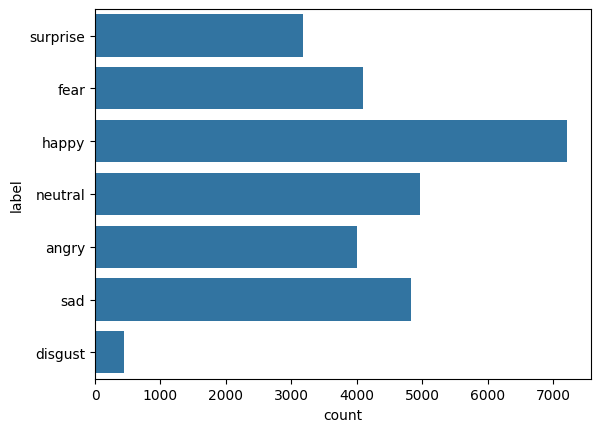

In [45]:
sns.countplot(train['label'])

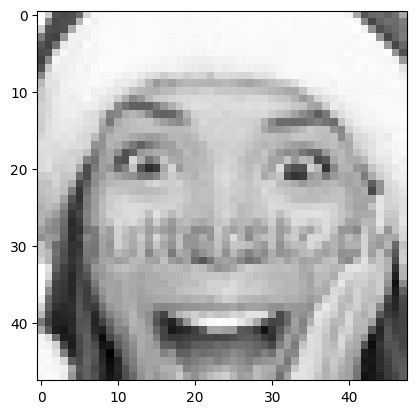

In [46]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

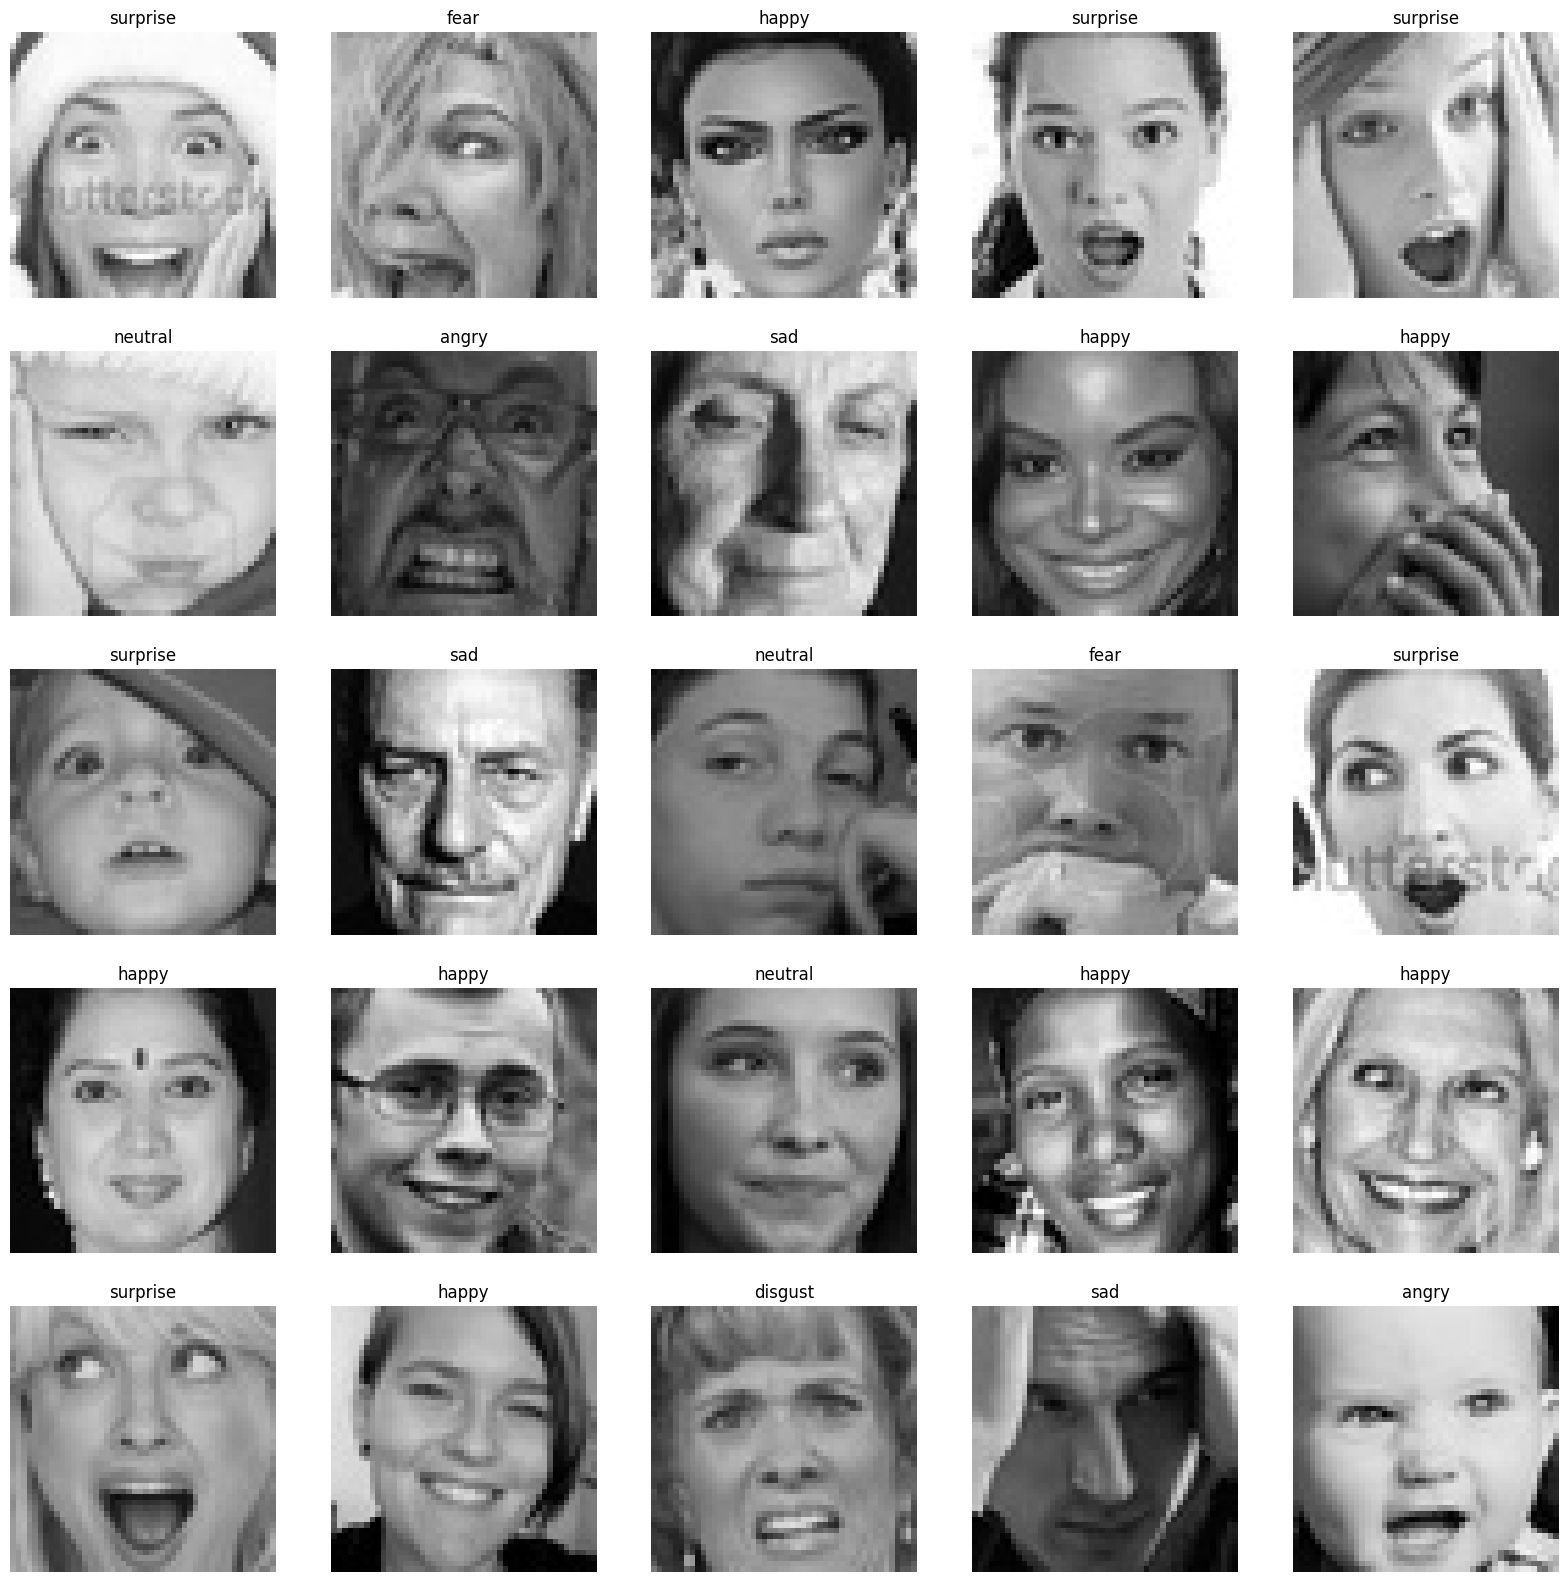

In [47]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [48]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [60]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [61]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [62]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [63]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [64]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [65]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [68]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming the dataset is already loaded and preprocessed

# Define PyTorch DataLoader for training and test data
batch_size = 128

train_data = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the CNN model in PyTorch
class CustomCNN(nn.Module):
    def __init__(self, input_shape, output_class):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3)
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_class)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

# Instantiate the model
input_shape = (1, 48, 48)  # Assuming input shape is (channels, height, width)
output_class = 7  # Change this according to your output class
model = CustomCNN(input_shape, output_class)



In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
epochs = 50
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 2.8912, val_loss: 1.8379, val_acc: 0.2558
Epoch [1], last_lr: 0.00008, train_loss: 2.2447, val_loss: 1.7996, val_acc: 0.2565
Epoch [2], last_lr: 0.00013, train_loss: 1.8922, val_loss: 1.7862, val_acc: 0.2638
Epoch [3], last_lr: 0.00020, train_loss: 1.7956, val_loss: 1.7721, val_acc: 0.2699
Epoch [4], last_lr: 0.00028, train_loss: 1.7482, val_loss: 1.7387, val_acc: 0.3252
Epoch [5], last_lr: 0.00037, train_loss: 1.6466, val_loss: 1.5856, val_acc: 0.3829
Epoch [6], last_lr: 0.00047, train_loss: 1.5494, val_loss: 1.4633, val_acc: 0.4404
Epoch [7], last_lr: 0.00057, train_loss: 1.4516, val_loss: 1.3734, val_acc: 0.4736
Epoch [8], last_lr: 0.00067, train_loss: 1.3674, val_loss: 1.2589, val_acc: 0.5182
Epoch [9], last_lr: 0.00076, train_loss: 1.3133, val_loss: 1.2246, val_acc: 0.5332
Epoch [10], last_lr: 0.00084, train_loss: 1.2604, val_loss: 1.2327, val_acc: 0.5354
Epoch [11], last_lr: 0.00091, train_loss: 1.2294, val_loss: 1.1759, val_acc: 0.5661
Ep

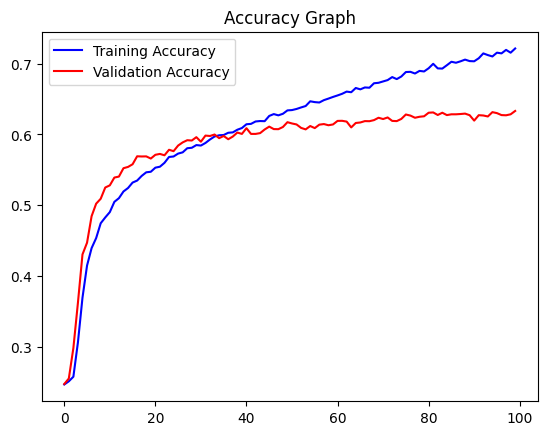

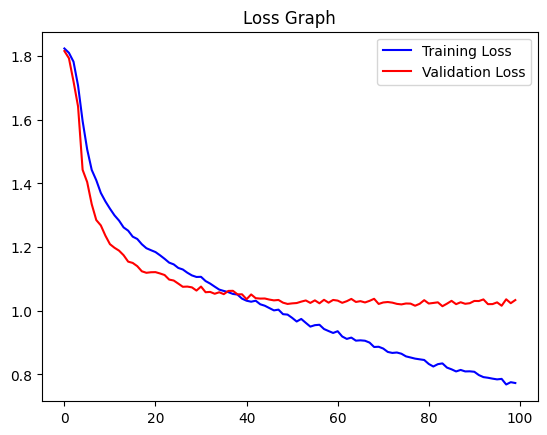

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [38]:
torch.save(model, 'fer2013.pt')

Original Output: disgust
1/1 [==============================] - 1s 501ms/step
Predicted Output: disgust


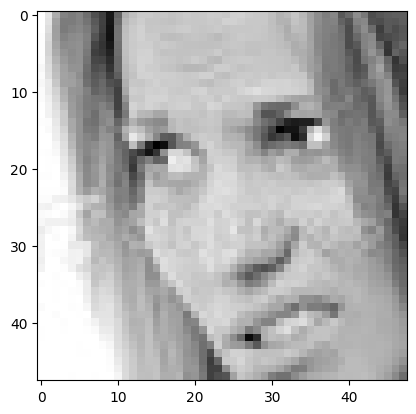

In [72]:


# Load the saved modle
modle = CustomCNN(input_shape, output_class)
modle.load_state_dict(torch.load('fer2013.pt'))
modle.eval()  # Set the modle to evaluation mode

# Function to perform prediction
def predict(modle, image):
    # Convert image to PyTorch tensor and add batch dimension
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        output = modle(image_tensor)
        _, predicted = torch.max(output, 1)

    return predicted.item()  # Return the predicted class index

# Get a random image index from the test dataset
image_index = random.randint(0, len(x_test) - 1)

# Print original label
print("Original Output:", le.inverse_transform([np.argmax(y_test[image_index])])[0])

# Perform prediction
predicted_class = predict(modle, x_test[image_index])

# Print predicted label
print("Predicted Output:", le.inverse_transform([predicted_class])[0])

# Display the image
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
plt.show()


In [2]:
! pip install tensorflow


  Using cached tensorflow-2.11.0-cp37-cp37m-macosx_10_14_x86_64.whl.metadata (3.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-macosx_10_9_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-3.19.6-cp37-cp37m-macosx_10_9_x86_64.whl.metadata (787 bytes)
  Using cached termcolor-2.3.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached grpcio-1.62.2-cp37-cp37m-macosx_10_10_universal2.whl.metadata (4.0 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.11.0-

In [1]:

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aadityasinghal/facial-expression-dataset
! unzip facial-expression-dataset


! unzip FaceEmotionRecognision.h5.zip




: 

: 

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('FaceEmotionRecognision.h5')

# Now you can use this model for inference


In [ ]:
import random
import pandas as pd
import os
TRAIN_DIR = './train/train/'
TEST_DIR = './test/test/'
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels
    ## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

In [ ]:
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from PIL import Image

import numpy as np
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])
x_train = train_features/255.0
x_test = test_features/255.0
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');